In [1]:
import os
import numpy as np
import pandas as pd

Note For this to work, you will need the `lsst.sims` stack to be installed. 
 - opsimsummary uses `healpy` which is installed with the sims stack, but also available from pip/conda
 - snsims uses the `lsst.sims` stack.

In [2]:
import opsimsummary as oss
import snsims
import healpy as hp

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## This section pertains to how to write a new Tiling class

```
noTile = snsims.Tiling()
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-9-5f6f8a94508e> in <module>()
----> 1 noTile = snsims.Tiling()

TypeError: Can't instantiate abstract class Tiling with abstract methods __init__, area, pointingSequenceForTile, tileIDSequence, tileIDsForSN
```

The class `snsims.Tiling` is an abstract Base class. Therefore, this cannot be instantiated. It must be subclassed, and the set of methods outlined have to be implemented for this to work.

In [4]:
class NoTile(snsims.Tiling):
    pass

In [5]:
noTile = NoTile()

TypeError: Can't instantiate abstract class NoTile with abstract methods __init__, area, pointingSequenceForTile, positions, tileIDSequence, tileIDsForSN


```
"""noTile = NoTile()
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-4-8ddedac7fb97> in <module>()
----> 1 noTile = NoTile()

TypeError: Can't instantiate abstract class NoTile with abstract methods __init__, area, pointingSequenceForTile, positions, tileIDSequence, tileIDsForSN
"""
```

The above fails because the methods are not implemented. Below is a stupid (ie. not useful) but minimalist class that would work:

In [6]:
class MyTile(snsims.Tiling):
    def __init__(self):
        pass
    @property
    def tileIDSequence(self):
        return np.arange(100)
    
    def tileIDsForSN(self, ra, dec):
        x = ra + dec
        y = np.remainder(x, 100.)
        return np.floor(y)
    def area(self, tileID):
        return 1.
    def pointingSequenceForTile(self, tileID, pointings):
        return None
    def positions(self):
        pass
    

In [7]:
myTile = MyTile()

## Using the class HealpixTiles

Currently there is only concrete tiling class that has been implemented. This is the `snsims.HealpixTiles` class.

This shows how to use the HealpixTiles Class

In [8]:
issubclass(snsims.HealpixTiles, snsims.Tiling)

True

In [9]:
help(snsims.HealpixTiles)

Help on class HealpixTiles in module snsims.healpixTiles:

class HealpixTiles(snsims.tessellations.Tiling)
 |  A concrete Tiling class based on Healpix Tiles. The user is
 |  allowed to choose the following parameters:
 |  
 |  Attributes
 |  ----------
 |  nside : int, power of 2, defaults to 256
 |      healpix nside parameter
 |  
 |  Method resolution order:
 |      HealpixTiles
 |      snsims.tessellations.Tiling
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nside=256, healpixelizedOpSim=None, preComputedMap=None)
 |      nside : int, power of 2, defaults to 256
 |          nside parameter of healpix. determines the size of the tiles
 |          so that there are 12 * nside **2 equally sized tiles covering
 |          the sphere.
 |  
 |  area(self, tileID)
 |  
 |  pointingSequenceForTile(self, tileID, allPointings, **kwargs)
 |      return a maximal sequence of pointings for a particular tileID
 |  
 |  positions(self, tileID, numSamples, rng=

In [10]:
datadir = os.path.join(oss.__path__[0], 'example_data')
opsimdb = os.path.join(datadir, 'enigma_1189_micro.db')

In [11]:
NSIDE = 4

In [12]:
hpOpSim = oss.HealPixelizedOpSim.fromOpSimDB(opsimdb, NSIDE=NSIDE)

 reading from database sqlite:////Users/rbiswas/.local/lib/python2.7/site-packages/opsimsummary/example_data/enigma_1189_micro.db
SELECT * FROM Summary WHERE PROPID in (366, 364)


In [46]:
NSIDE

4

In [39]:
hpTileshpOpSim = snsims.HealpixTiles(healpixelizedOpSim=hpOpSim, nside=NSIDE)

In [40]:
hpTileshpOpSim.pointingSequenceForTile(1, allPointings=None)

array([], dtype=int64)

In [59]:
phi, theta = hpTileshpOpSim.positions(1, 10000)

In [60]:
mapvals = np.ones(hp.nside2npix(NSIDE)) * hp.UNSEEN

In [61]:
mapvals[1] = 100

In [62]:
hp.ang2pix(NSIDE, np.radians(theta), np.radians(phi), nest=True)

array([1, 1, 1, ..., 1, 1, 1])

In [69]:
theta_c, phi_c = hp.pix2ang(4, 1, nest=True)

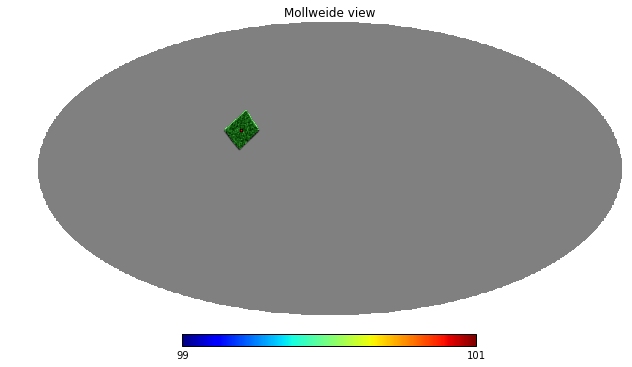

In [77]:
hp.mollview(mapvals, nest=True)
hp.projscatter(np.radians(theta), np.radians(phi), **dict(s=0.0002))
hp.projscatter(theta_c, phi_c, **dict(s=8., c='r'))

In [13]:
%timeit hpTileshpOpSim.pointingSequenceForTile(33, allPointings=None)

10 loops, best of 3: 33.7 ms per loop


In [16]:
preCompMap = os.path.join(oss.__path__[0], 'example_data', 'healpixels_micro.db')

In [17]:
hpTilesMap = snsims.HealpixTiles(nside=1, preComputedMap=preCompMap)

In [18]:
hpTilesMap.pointingSequenceForTile(10, allPointings=None)

array([171077, 171078, 171079, ..., 272594, 272626, 272656])

In [19]:
%timeit hpOpSim.obsHistIdsForTile(34)

10 loops, best of 3: 32 ms per loop


In [21]:
hpTiles = snsims.HealpixTiles(healpixelizedOpSim=hpOpSim)

In [22]:
hpTiles.pointingSequenceForTile(34, allPointings=None)

array([185874, 185905, 187057, 187059, 187073, 187074, 194374, 194377,
       194418, 194421, 195237, 195238, 195303, 195308, 196401, 201725,
       203413, 203421, 203439, 203455, 203480, 204360, 204375, 205282,
       205298, 206016, 206062, 206977, 210909, 211229, 211262, 212812,
       214181, 214218, 214247, 215735, 215778, 215913, 218394, 220583,
       220621, 230461, 230462, 230508, 230509, 233394, 233432, 234057,
       234073, 234829, 234831, 234875, 234881, 235681, 235724, 235779,
       235805, 236380, 236383, 236434, 236435, 239399, 239436, 243014,
       243050, 244790, 246727, 246747, 248059, 248094, 250165, 250205,
       251002, 251676, 253032, 253033, 253069, 253070, 253742, 253776,
       255888, 255893, 262252, 266477, 266478, 266489, 269957])